In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [3]:
#%time topo_midres = topo_hires[:-1,:-1].coarsen(latitude=10,longitude=10).mean()
#topo_midres.to_netcdf("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4_coarse.nc")
topo_midres = xr.open_dataarray("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4_coarse.nc")

In [4]:
e5_pr_seasmean = 1e3*e5_climatology('128_228_tp',range(2001,2021))

5.632752895355225


In [5]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)


for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp()
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [6]:
for MR in MRs:
    print(MR.name)
    MR.set_daily_spavg_var('162_071_viwve','VIWVE','vinteg',where='upstream')
    MR.set_daily_spavg_var('162_072_viwvn','VIWVN','vinteg',where='upstream')
    MR.set_viwvperp_sfc()
    MR.set_daily_imerg()
    MR.set_daily_sfc_var('128_034_sstk','SST')
    MR.vars['UBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.uDBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['VBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.vDBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.set_daily_DBl_vars()
    
    for varname in 'SST','THETAEBSEMI','TLSEMI','QLSEMI','BLSEMI','GPM_PR':
        grid = MR.vars[varname+'_DAILY']
        MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)


ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [7]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [8]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='', labelpos='E', coordinates='axes',color='k',angle=90)
    return q
def add_latlon(ax,box):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
        

# Fig - wind regressed onto TL

In [9]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [10]:
new_cmap = truncate_colormap(plt.cm.plasma,0.2,1)

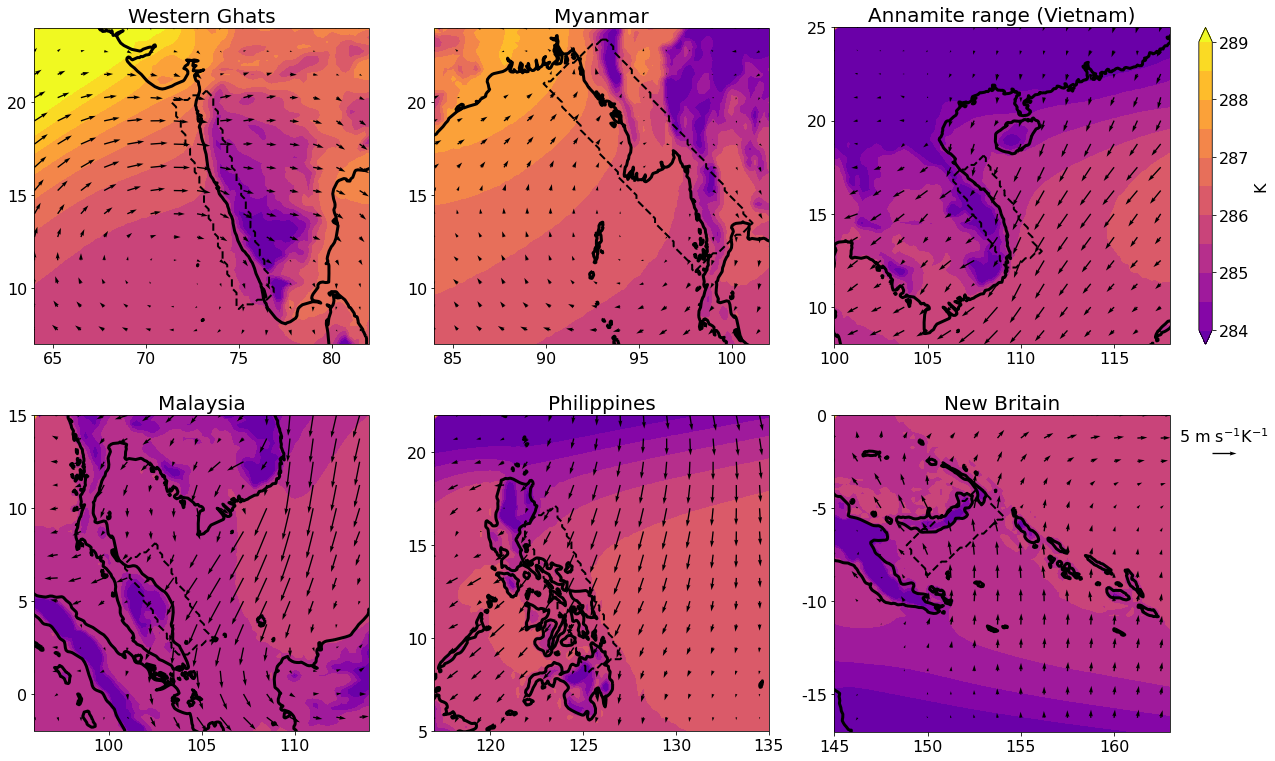

In [13]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = -MR.vars['TLSEMI_ABOVE_DAILY']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    tmean = MR.vars['TLSEMI_DAILY'].mean('time')
    tmean[0,0]=290
    tmean[0,1]=283
    c = tmean.plot.contourf(ax=ax,add_colorbar=False,levels=np.linspace(284,289,11),cmap=new_cmap)
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    Q = add_wind(ax,u,v,width=0.004,scale=70,key=False)

    #np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    #sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'K')

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.16, 0.88, 5, r'5 m s$^{-1}$K$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

    
fig.tight_layout()


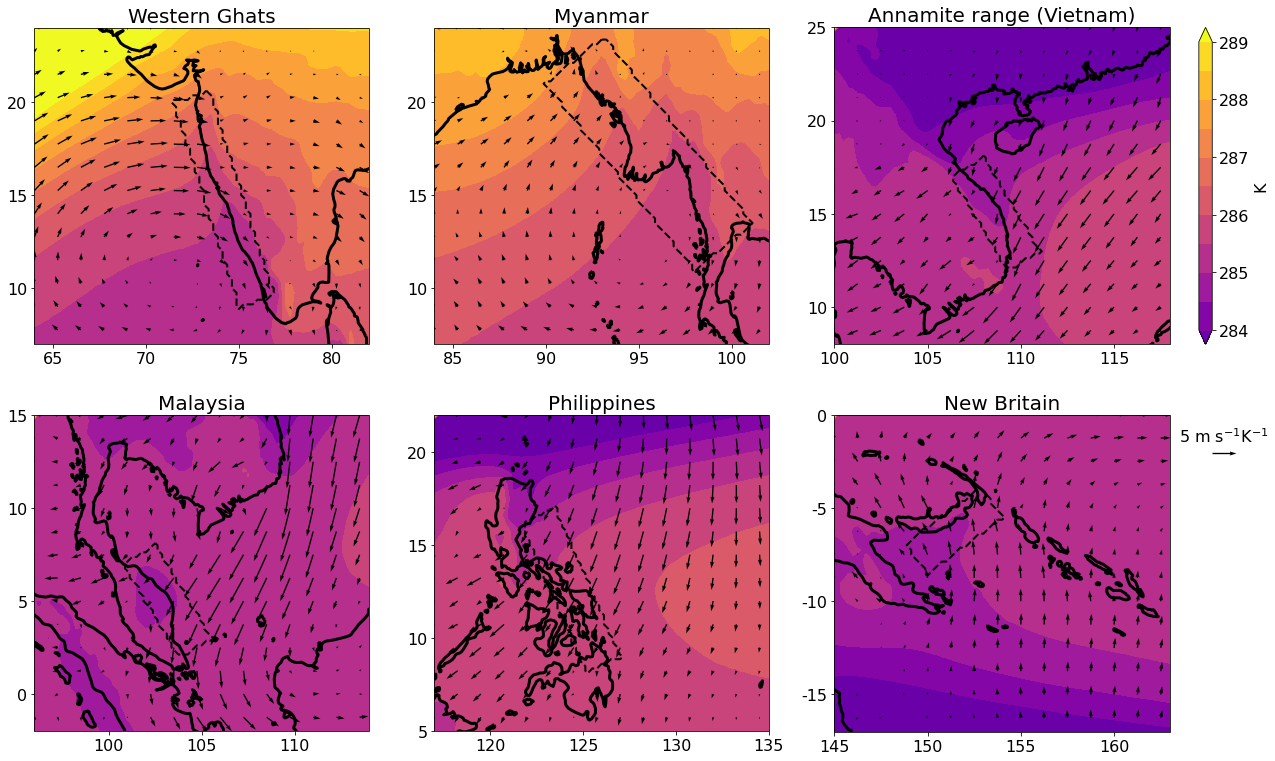

# Fig - wind regressed onto qL

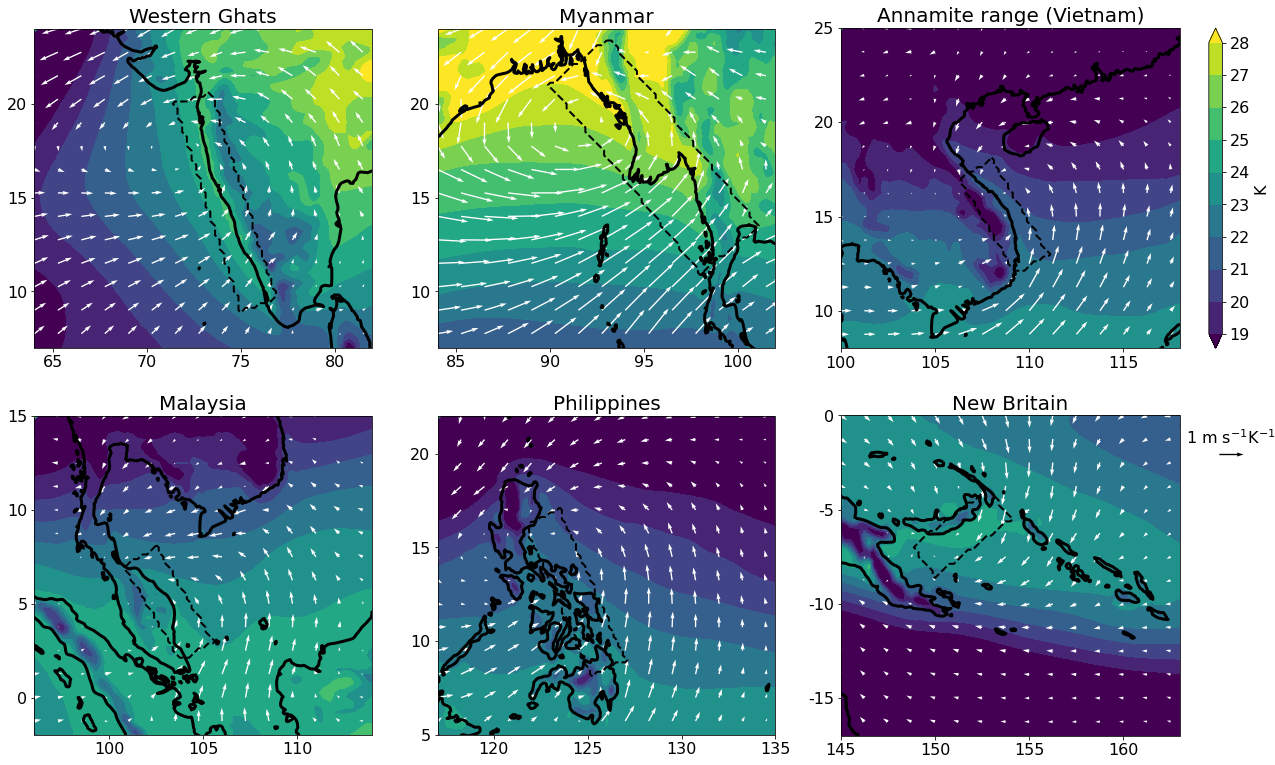

In [14]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = MR.vars['QLSEMI_ABOVE_DAILY']*2.5e3
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    qmean = (MR.vars['QLSEMI_DAILY'].mean('time')*2.5e3)
    qmean[0,0] = 29.
    qmean[-1,0] = 18.
    c = qmean.plot.contourf(ax=ax,add_colorbar=False,levels= np.arange(19,29.,1.),cmap=plt.cm.viridis)
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    Q = add_wind(ax,u,v,color='w',width=0.004,scale=14,key=False)

    #np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    #sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'K')#,ticks=np.arange(10,35,5))

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.15, 0.88, 1, r'1 m s$^{-1}$K$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

    
fig.tight_layout()


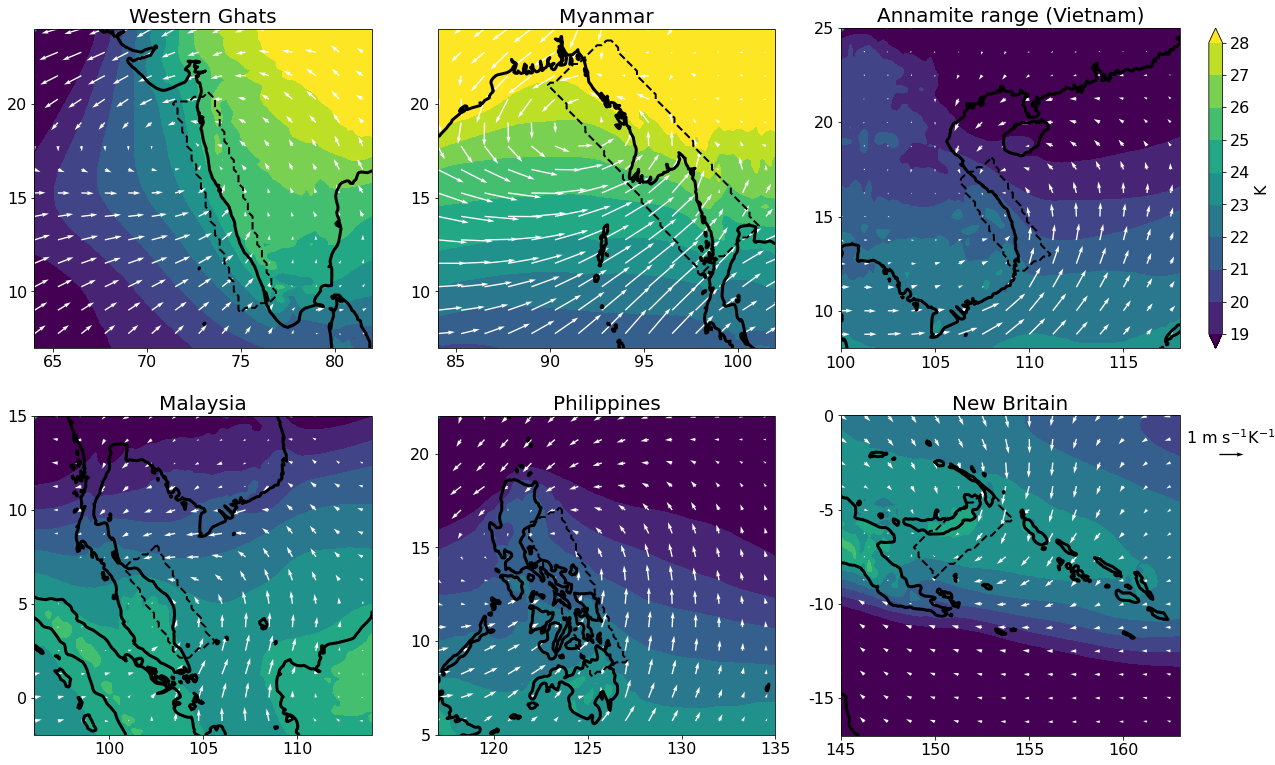

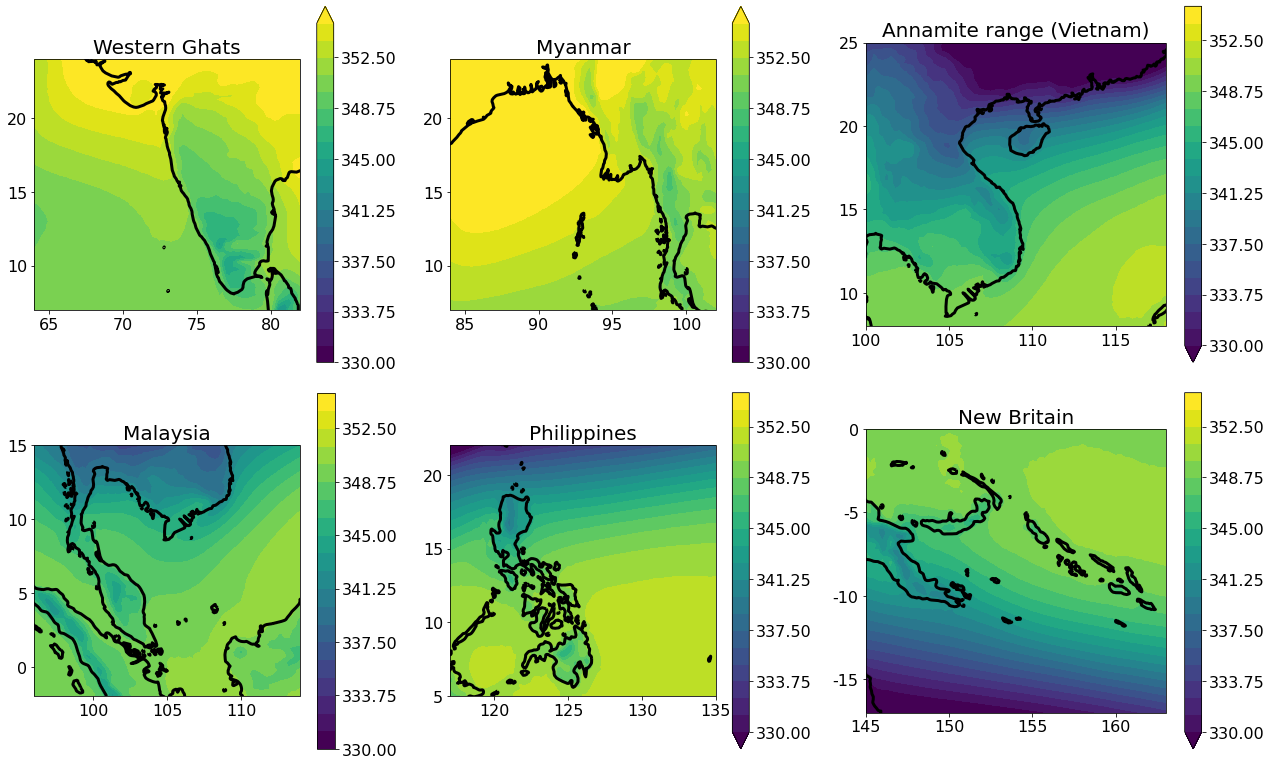

In [15]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = MR.vars['THETAEBSEMI_DAILY'].mean('time')
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    pred.plot.contourf(ax=ax,levels=np.linspace(330,355,21))
    
    #ureg = linregress_xr_2(pred,u)
    #vreg = linregress_xr_2(pred,v)
    #fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    #u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    #Q = add_wind(ax,u,v,color='w',width=0.005,scale=14,key=False)

    #np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    #tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    #sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)
    
    ax.set_title(MR.Lname,fontsize=20)


    
fig.tight_layout()


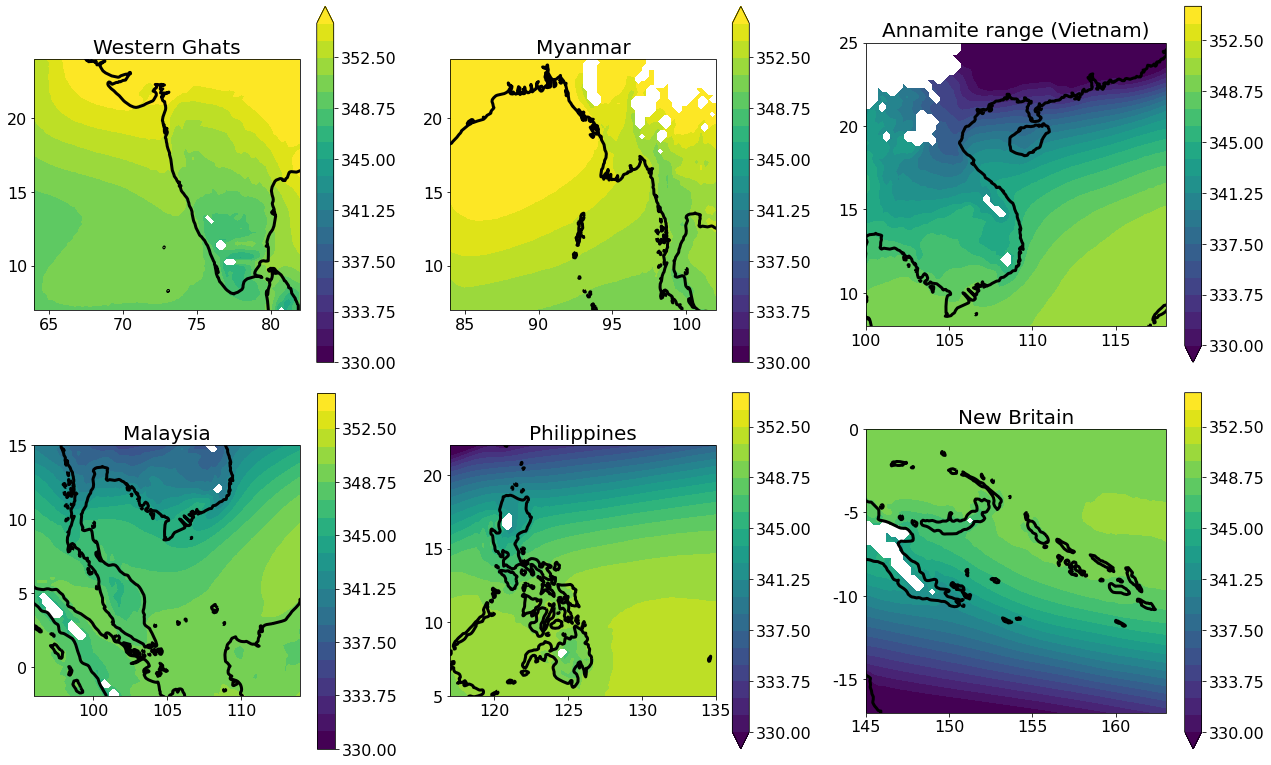

# Fig - precip regressed onto precip

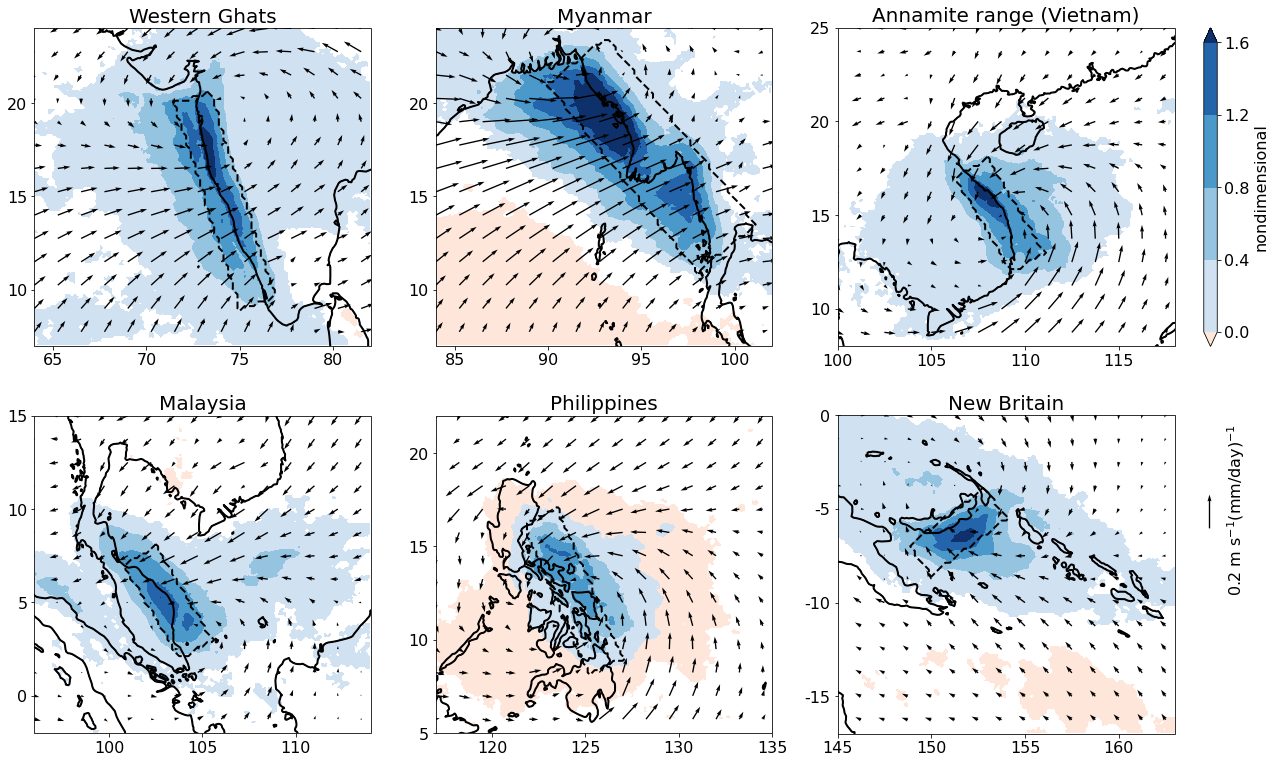

In [16]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = MR.vars['GPM_PR_ABOVE_DAILY']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    prreg = linregress_xr_2(pred,MR.vars['GPM_PR_DAILY'].transpose('time','latitude','longitude'))
    prregpr = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.01)
    
    c = prregpr.plot.contourf(ax=ax,add_colorbar=False,levels= np.arange(0,1.7,0.4),colors=('#FEE6DA','#D0E1F2','#95C4E0','#4A99CA','#2364AB','#0F316B'))
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    MR.uregpr = u
    MR.vregpr = v
    Q = add_wind(ax,MR.uregpr,MR.vregpr,color='k',width=0.004,scale=2,key=False)

    #np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    #sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=2)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'nondimensional')#,ticks=np.arange(10,35,5))

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.1, 0.7, 0.2,label='', labelpos='N',
                   coordinates='axes',color='k',angle=90)
axs[5].text(1.15, 0.45, r'0.2 m s$^{-1}$(mm/day)$^{-1}$',transform=axs[5].transAxes,color='k',rotation=90)
    
fig.tight_layout()


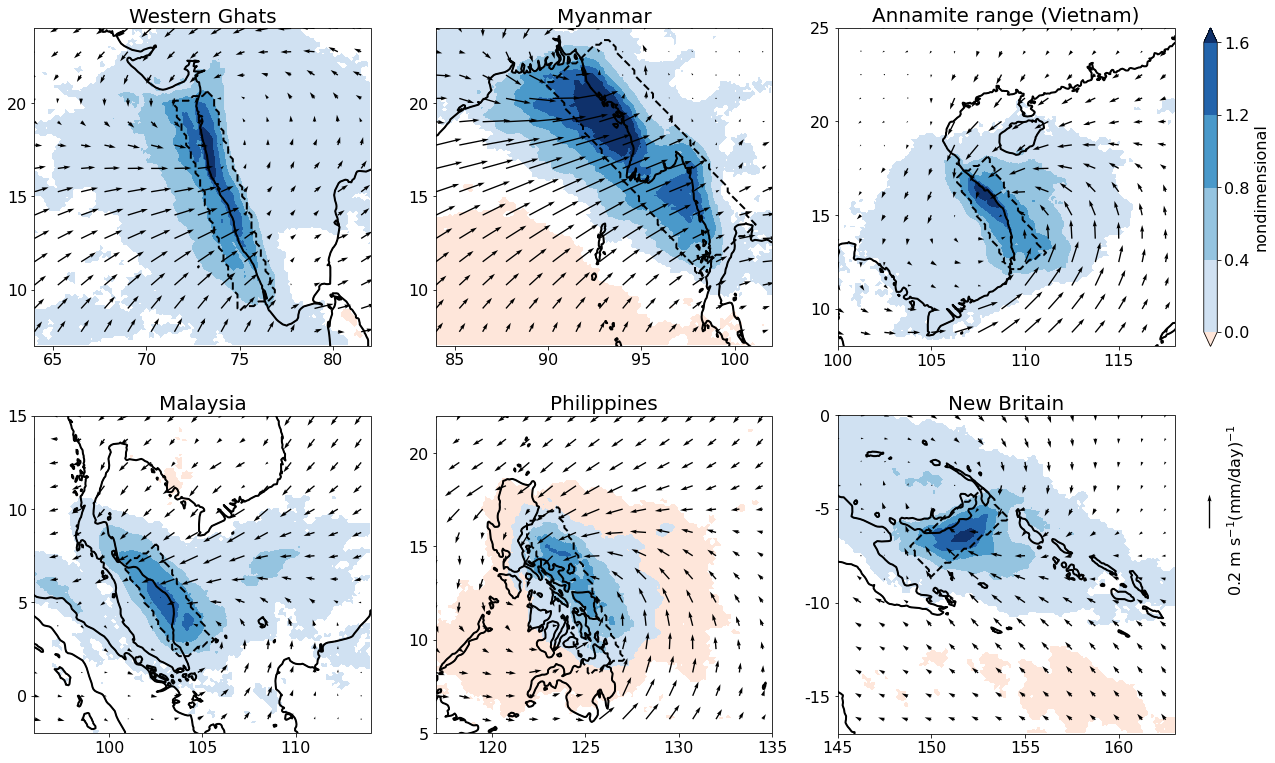

# Fig - BL spatial maps

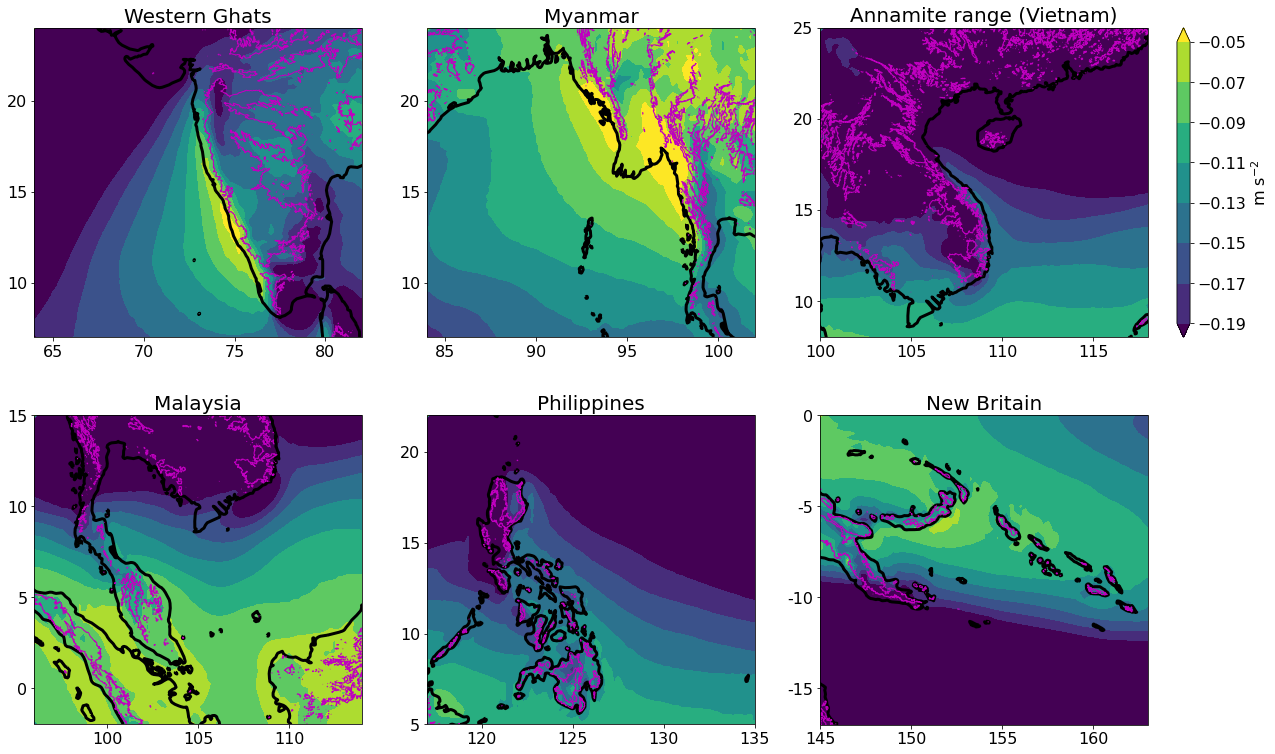

In [17]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    BL = (MR.vars['BLSEMI_DAILY'].mean('time'))
    BL[0,0] = -0.04
    BL[-1,0] = -0.2
    c = BL.plot.contourf(ax=ax,add_colorbar=False,transform=ccrs.PlateCarree(),levels=np.arange(-0.19,-0.04,0.02))
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['m'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'm s$^{-2}$')

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

fig.tight_layout()


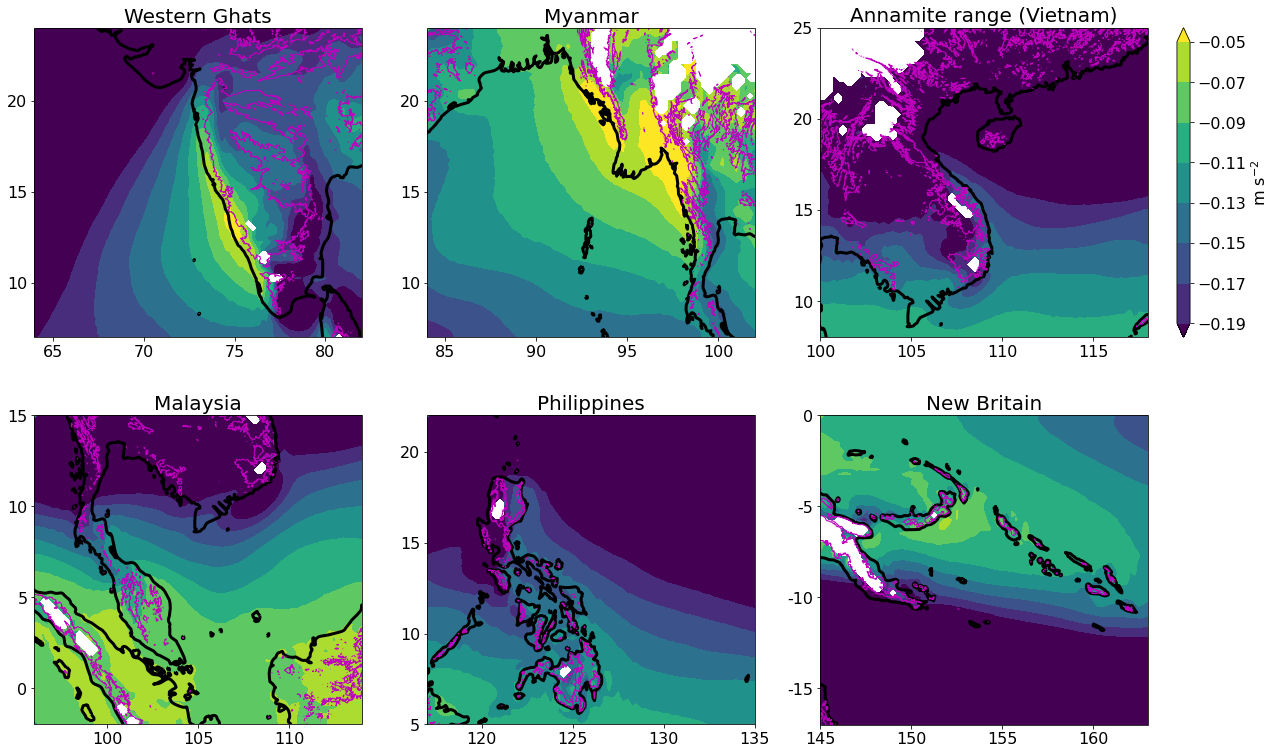